# Session 10
    fifa_2019.csv dataset

In [1]:
# Lets import some libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

%matplotlib inline

2023-01-30 15:11:46.765717: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-30 15:11:46.880171: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-30 15:11:47.498230: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-30 15:11:47.498294: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

In [2]:
# Some basic parameters

inpDir = '../input' # location where input data is stored
outDir = '../output' # location to store outputs
modelDir = '../models'
subDir = 'fifa_2019'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production

np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
 
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well


EPOCHS = 100 # number of epochs
ALPHA = 0.1 # learning rate

BATCH_SIZE = 256 # other sizes leave last batch partial

TRAIN_SIZE = int(BATCH_SIZE*64) # to create 64 batches of 256 rows each

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,15),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.brg

plt.rcParams.update(params) # update rcParams

In [3]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2023-01-30 15:11:48.125464: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-30 15:11:48.125492: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pankajgharde): /proc/driver/nvidia/version does not exist


In [4]:
data_df = pd.read_csv("./datasets/fifa_2019.csv")
data_df.shape

(18207, 89)

In [5]:
# removing rows with position = null
data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [6]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [7]:
# Are there NaNs Still?
data_df.isna().sum()

Position           0
Finishing          0
HeadingAccuracy    0
ShortPassing       0
Volleys            0
Dribbling          0
Curve              0
FKAccuracy         0
LongPassing        0
BallControl        0
Acceleration       0
SprintSpeed        0
Agility            0
Reactions          0
Balance            0
ShotPower          0
Jumping            0
Stamina            0
Strength           0
LongShots          0
Aggression         0
Interceptions      0
Positioning        0
Vision             0
Penalties          0
Composure          0
Marking            0
StandingTackle     0
SlidingTackle      0
GKDiving           0
GKHandling         0
GKKicking          0
GKPositioning      0
GKReflexes         0
dtype: int64

In [8]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [9]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0
#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1
#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2
#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3
# Convert Column "Position" to numeric so that Pandas does not complain
data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [10]:
labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [11]:
y = data_df["Position"].values
X = data_df.drop("Position", axis = 1)

In [12]:
# one hot encoding
y = pd.get_dummies(y).values
y

array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0]], dtype=uint8)

In [13]:
#  Split the data in training and test sets to measure performance of the model.
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE, stratify=y, random_state=RANDOM_STATE)
print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(16384, 33) (16384, 4) (1763, 33) (1763, 4)


In [14]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [15]:
X_train.shape

(16384, 33)

In [16]:
# Callig class Sequential and pass all layers as a list
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(18, activation='swish'), # alternatively activation = tf.nn.silu
  tf.keras.layers.Dense(4) # notice absense of softmax function
])

2023-01-30 15:11:48.617038: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
X_train[:1].shape

(1, 33)

In [18]:
predictions = model(X_train[:1]).numpy()
predictions

array([[-0.4859373 , -0.97178483,  1.3132412 , -0.78459144]],
      dtype=float32)

In [19]:
predictions.sum()

-0.9290724

In [20]:
tf.nn.softmax(predictions).numpy()

array([[0.11902392, 0.07322062, 0.71946156, 0.08829385]], dtype=float32)

In [21]:
tf.nn.softmax(predictions).numpy().sum()

0.99999994

In [22]:
'''
Number of parameters:
    layer 1 : 33*18 +18 = 612 
    layer 2 : 18*4 + 4
We are not locking any layer hence all parameter are trainable    
'''

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (1, 18)                   612       
                                                                 
 dense_1 (Dense)             (1, 4)                    76        
                                                                 
Total params: 688
Trainable params: 688
Non-trainable params: 0
_________________________________________________________________


In [23]:
sys.float_info.max

1.7976931348623157e+308

In [24]:
sys.float_info.min

2.2250738585072014e-308

In [25]:
np.log(sys.float_info.max)

709.782712893384

In [26]:
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits = True)

In [27]:
y_train[:1]

array([[0, 0, 1, 0]], dtype=uint8)

In [28]:
loss_fn(y_train[:1], predictions).numpy()

0.32925218

In [29]:
# Loss function to minimize
# Optimizer
# List of metrics to monitor
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

In [30]:
history = model.fit(X_train, y_train, validation_data=[X_test, y_test], batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/100
64/64 [==============================] - 1s 4ms/step - loss: 0.8758 - accuracy: 0.6735 - val_loss: 0.6532 - val_accuracy: 0.7601
Epoch 2/100
64/64 [==============================] - 0s 2ms/step - loss: 0.5483 - accuracy: 0.7928 - val_loss: 0.4902 - val_accuracy: 0.8049
Epoch 3/100
64/64 [==============================] - 0s 2ms/step - loss: 0.4477 - accuracy: 0.8212 - val_loss: 0.4262 - val_accuracy: 0.8264
Epoch 4/100
64/64 [==============================] - 0s 2ms/step - loss: 0.4017 - accuracy: 0.8369 - val_loss: 0.3881 - val_accuracy: 0.8395
Epoch 5/100
64/64 [==============================] - 0s 2ms/step - loss: 0.3736 - accuracy: 0.8481 - val_loss: 0.3660 - val_accuracy: 0.8486
Epoch 6/100
64/64 [==============================] - 0s 2ms/step - loss: 0.3558 - accuracy: 0.8547 - val_loss: 0.3486 - val_accuracy: 0.8508
Epoch 7/100
64/64 [==============================] - 0s 2ms/step - loss: 0.3433 - accuracy: 0.8610 - val_loss: 0.3406 - val_accuracy: 0.8554
Epoch 8/100
6

Epoch 59/100
64/64 [==============================] - 0s 2ms/step - loss: 0.2790 - accuracy: 0.8848 - val_loss: 0.2872 - val_accuracy: 0.8826
Epoch 60/100
64/64 [==============================] - 0s 2ms/step - loss: 0.2782 - accuracy: 0.8855 - val_loss: 0.2871 - val_accuracy: 0.8815
Epoch 61/100
64/64 [==============================] - 0s 2ms/step - loss: 0.2782 - accuracy: 0.8849 - val_loss: 0.2872 - val_accuracy: 0.8815
Epoch 62/100
64/64 [==============================] - 0s 2ms/step - loss: 0.2787 - accuracy: 0.8853 - val_loss: 0.2875 - val_accuracy: 0.8832
Epoch 63/100
64/64 [==============================] - 0s 2ms/step - loss: 0.2775 - accuracy: 0.8859 - val_loss: 0.2874 - val_accuracy: 0.8849
Epoch 64/100
64/64 [==============================] - 0s 2ms/step - loss: 0.2780 - accuracy: 0.8856 - val_loss: 0.2878 - val_accuracy: 0.8832
Epoch 65/100
64/64 [==============================] - 0s 2ms/step - loss: 0.2776 - accuracy: 0.8854 - val_loss: 0.2879 - val_accuracy: 0.8837
Epoch 

In [31]:
#model Evalution
model.evaluate (X_test,  y_test, verbose=2)

56/56 - 0s - loss: 0.2877 - accuracy: 0.8832 - 76ms/epoch - 1ms/step


[0.2877240777015686, 0.8831537365913391]

In [34]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

,loss,accuracy,val_loss,val_accuracy
0,0.875820,0.673462,0.653181,0.760068
1,0.548260,0.792847,0.490215,0.804878
2,0.447659,0.821228,0.426243,0.826432
3,0.401718,0.836914,0.388148,0.839478
4,0.373608,0.848083,0.366045,0.848554


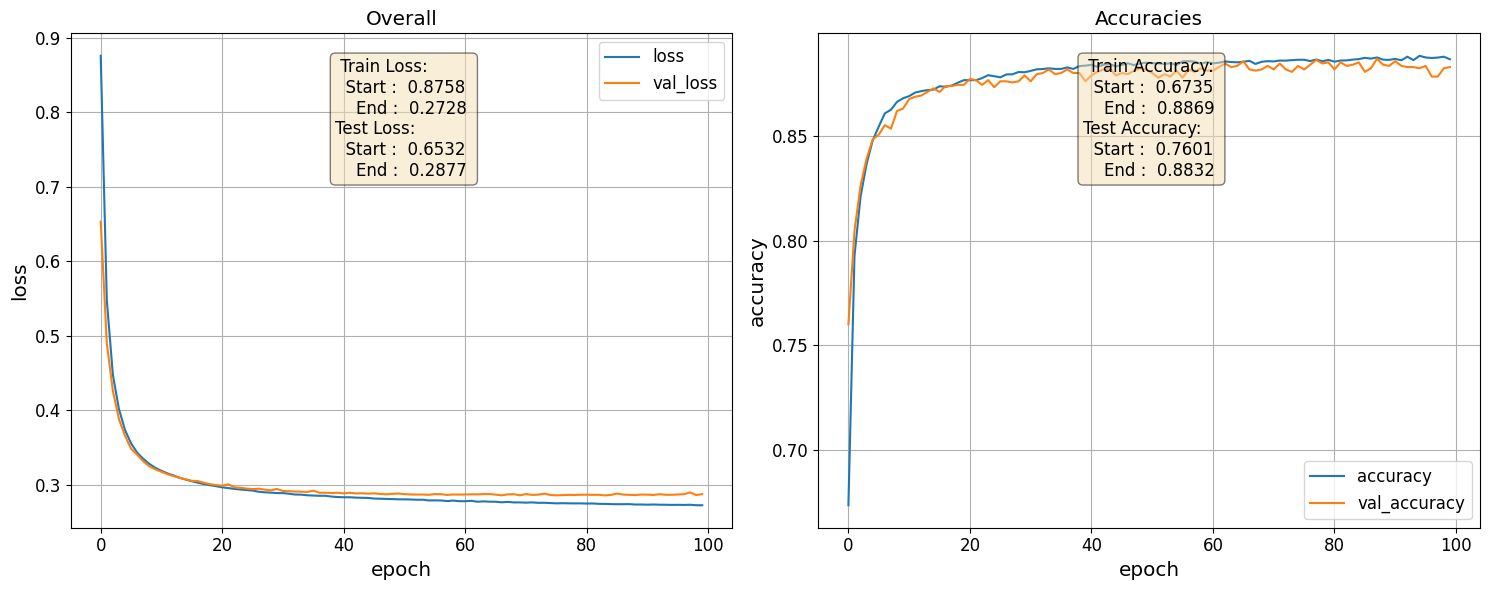

In [35]:
fig, axes = plt.subplots(1,2 , figsize = (15,6),)

l_range = 10 # ignoring first few records
y1_var = 'loss'
y2_var = 'val_loss'

ax = axes[0]

loss_df[[y1_var, y2_var]].plot( ax = ax)

# get values for plotting
st_loss = loss_df[y1_var].iloc[0]
end_loss = loss_df[y1_var].iloc[-1]
t_st_loss = loss_df[y2_var].iloc[0]
t_end_loss = loss_df[y2_var].iloc[-1]

# little beautification
train_txtstr = "Train Loss: \n  Start : {:7.4f}\n    End : {:7.4f}".format( st_loss, end_loss )    # Train text to plot
test_txtstr = "Test Loss: \n  Start : {:7.4f}\n    End : {:7.4f}".format( t_st_loss, t_end_loss ) # Test text to plot
txtstr = ' {} \n{}'.format(train_txtstr, test_txtstr)

# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)

ax.set_xlabel('epoch')
ax.set_ylabel(y1_var)
ax.set_title('Overall')
ax.grid();

ax = axes[1]

y1_var = 'accuracy'
y2_var = 'val_accuracy'

loss_df[[y1_var, y2_var]].plot( ax = ax)

# get values for plotting
st_loss = loss_df[y1_var].iloc[0]
end_loss = loss_df[y1_var].iloc[-1]
t_st_loss = loss_df[y2_var].iloc[0]
t_end_loss = loss_df[y2_var].iloc[-1]

# little beautification
train_txtstr = "Train Accuracy: \n  Start : {:7.4f}\n    End : {:7.4f}".format( st_loss, end_loss )    # Train text to plot

test_txtstr = "Test Accuracy: \n  Start : {:7.4f}\n    End : {:7.4f}".format( t_st_loss, t_end_loss ) # Test text to plot# properties  matplotlib.patch.Patch 
txtstr = ' {} \n{}'.format(train_txtstr, test_txtstr)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

ax.set_xlabel('epoch')
ax.set_ylabel(y1_var)
ax.set_title('Accuracies'.format(l_range))
ax.grid();
plt.tight_layout()

## Predictions

In [36]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [37]:
y_pred = probability_model(X_train).numpy()
y_pred

array([[2.34151162e-06, 4.55255649e-04, 7.96331942e-01, 2.03210548e-01],
       [2.39377687e-06, 9.13256884e-01, 8.67231190e-02, 1.76569265e-05],
       [1.22187743e-07, 1.12200969e-05, 2.79628813e-01, 7.20359743e-01],
       ...,
       [1.14825871e-05, 2.26574987e-01, 6.64157987e-01, 1.09255597e-01],
       [5.75837262e-08, 3.61277148e-06, 7.52257526e-01, 2.47738868e-01],
       [7.12547262e-05, 8.89138758e-01, 1.09106354e-01, 1.68364239e-03]],
      dtype=float32)

In [38]:
print(classification_report(np.argmax(y_train, axis = 1), np.argmax(y_pred, axis = 1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1828
           1       0.92      0.94      0.93      5296
           2       0.85      0.86      0.85      6174
           3       0.84      0.80      0.82      3086

    accuracy                           0.89     16384
   macro avg       0.90      0.90      0.90     16384
weighted avg       0.89      0.89      0.89     16384



In [39]:
y_pred = probability_model(X_test).numpy()
print('Accuracy score on Test Data :{:.5f}'.format(accuracy_score(np.argmax(y_test, axis = 1), 
                                                                  np.argmax(y_pred, axis = 1))))

Accuracy score on Test Data :0.88315


In [40]:
print(classification_report(np.argmax(y_test, axis = 1), 
                            np.argmax(y_pred, axis = 1)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       197
           1       0.92      0.93      0.93       570
           2       0.83      0.87      0.85       664
           3       0.86      0.76      0.81       332

    accuracy                           0.88      1763
   macro avg       0.90      0.89      0.90      1763
weighted avg       0.88      0.88      0.88      1763



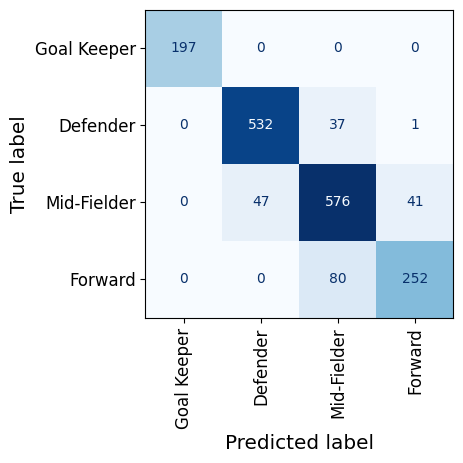

In [41]:
cm  = confusion_matrix(np.argmax(y_test, axis = 1), np.argmax(y_pred, axis = 1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels.values())

fig, ax = plt.subplots(figsize = (4,4))
disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

plt.show();

In [42]:
loss_df[loss_df['val_loss'] == loss_df['val_loss'].min()]

,loss,accuracy,val_loss,val_accuracy
83,0.2746,0.886719,0.286006,0.884288


# Assignment: S10-01

1. Implement L2 Regularization 
2. Change data set to Fashion MNIST 